# NLTK VADER sentiment analysis

Importing necessary libraries

In [11]:
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd
import re
import string

# Import API key from config.py
from config import API_KEY

Setting up the YouTube API

In [12]:
api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=API_KEY)

# Request video comments and store in dataframe
request = youtube.commentThreads().list(
    part="snippet",
    videoId="pL064KP46UE",
    maxResults=100
)
response = request.execute()

comments = []

# Loop through response and store comments in list. Retrieves the snippet of the top level comment and the text display
# top level comment is the comment that is not a reply to another comment
for item in response['items']:
    comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
    comments.append(comment_text)

df = pd.DataFrame(comments, columns=['comment'])

# df.to_csv('comments.csv', index=False)

df.head(10)

,comment
0,Test your Office know-how with The Office Holi...
1,&quot;I threw the keys in out of anger&quot; <...
2,phyllis snorting &amp; dwight opening the door...
3,Tho half of this actually made the final cut ..
4,"<a href=""https://www.youtube.com/watch?v=pL064..."
5,what do you mean so we don&#39;t have to?..the...
6,How is Michael more mature in the deleted scenes
7,Why were these scenes deleted is all I want to...
8,Not Michael calling Pam pervy.. 😭😂
9,"I love the self awareness @<a href=""https://ww..."


In [13]:
# data type of the dataframe
print(df.dtypes)

comment    object
dtype: object


Downloading resources and setting up the model

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# nltk.download('punkt') # one time execution
# nltk.download('stopwords') # one time execution
# nltk.download('vader_lexicon') # one time execution

Preprocessing the data

In [15]:
def preprocess_comment(comment):
    # Remove HTML tags
    comment = re.sub(r'<.*?>', '', comment)

    # Replace HTML character codes with ASCII equivalent
    comment = re.sub(r'&amp;', '&', comment)
    comment = re.sub(r'&quot;', '"', comment)
    comment = re.sub(r'&#39;', "'", comment)

    # Convert text to lowercase
    comment = comment.lower()

    # Remove URLs
    comment = re.sub(r'http\S+', '', comment)

    # Remove punctuation (optional: consider keeping emoticons)
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(comment)
    filtered_comment = [word for word in word_tokens if word not in stop_words]

    return ' '.join(filtered_comment)

In [16]:
# Apply preprocessing to each comment
df['processed_comment'] = df['comment'].apply(preprocess_comment)

Defining and applying sentiment analysis function

In [17]:
def analyze_sentiment_vader(comment):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(comment)
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

Collating the results and displaying the dataframe

In [18]:
# Sentiment analysis on the processed comments
df['sentiment'] = df['processed_comment'].apply(analyze_sentiment_vader)

# df.to_csv('comments_processed.csv', index=False)

# Display the DataFrame
display(df.head(10))

,comment,processed_comment,sentiment
0,Test your Office know-how with The Office Holi...,"Test Office know-how The Office Holiday quiz ,...",Positive
1,&quot;I threw the keys in out of anger&quot; <...,`` I threw keys anger '' Now THAT killed 😂,Negative
2,phyllis snorting &amp; dwight opening the door...,phyllis snorting & dwight opening door w butt ...,Neutral
3,Tho half of this actually made the final cut ..,Tho half actually made final cut ..,Negative
4,"<a href=""https://www.youtube.com/watch?v=pL064...",1:41 love Dwight exhibits objects like art gal...,Positive
5,what do you mean so we don&#39;t have to?..the...,mean n't ? .. good,Negative
6,How is Michael more mature in the deleted scenes,How Michael mature deleted scenes,Positive
7,Why were these scenes deleted is all I want to...,Why scenes deleted I want know ... anyone ?,Positive
8,Not Michael calling Pam pervy.. 😭😂,Not Michael calling Pam pervy .. 😭😂,Neutral
9,"I love the self awareness @<a href=""https://ww...",I love self awareness @ 4:12 🤣,Positive


In [19]:
processed_df = df.drop(columns=['comment'])

# Save to csv
# processed_df.to_csv('comments_processed.csv', index=False)

# Display the DataFrame
display(processed_df.head(10))

,processed_comment,sentiment
0,"Test Office know-how The Office Holiday quiz ,...",Positive
1,`` I threw keys anger '' Now THAT killed 😂,Negative
2,phyllis snorting & dwight opening door w butt ...,Neutral
3,Tho half actually made final cut ..,Negative
4,1:41 love Dwight exhibits objects like art gal...,Positive
5,mean n't ? .. good,Negative
6,How Michael mature deleted scenes,Positive
7,Why scenes deleted I want know ... anyone ?,Positive
8,Not Michael calling Pam pervy .. 😭😂,Neutral
9,I love self awareness @ 4:12 🤣,Positive


Evaluating the processed data

Percentage of positive comments: 44.00%
Percentage of negative comments: 21.00%
Percentage of neutral comments: 35.00%


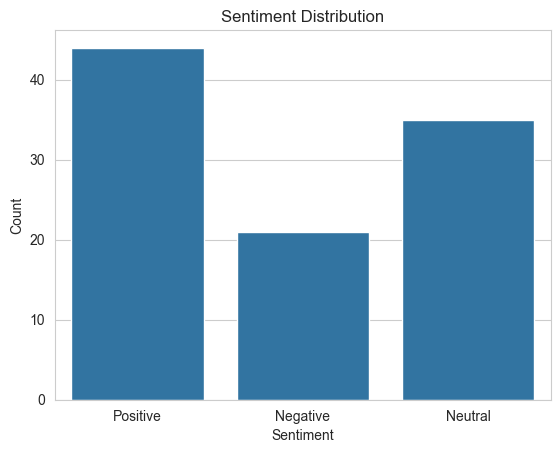

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of positive, negative and neutral comments
positive_comments = processed_df[processed_df['sentiment'] == 'Positive']
negative_comments = processed_df[processed_df['sentiment'] == 'Negative']
neutral_comments = processed_df[processed_df['sentiment'] == 'Neutral']

print('Percentage of positive comments: {:.2f}%'.format(len(positive_comments) / len(processed_df) * 100))
print('Percentage of negative comments: {:.2f}%'.format(len(negative_comments) / len(processed_df) * 100))
print('Percentage of neutral comments: {:.2f}%'.format(len(neutral_comments) / len(processed_df) * 100))


# Plot the sentiment distribution
sns.set_style('whitegrid')
sns.countplot(x='sentiment', data=processed_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()